In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Used to change filepaths
from pathlib import Path
import matplotlib.pyplot as plt
import IPython
from IPython.display import display
from PIL import Image
%matplotlib inline
import os
print(os.listdir("../input"))

['trashnet']


In [2]:
#!tree ..

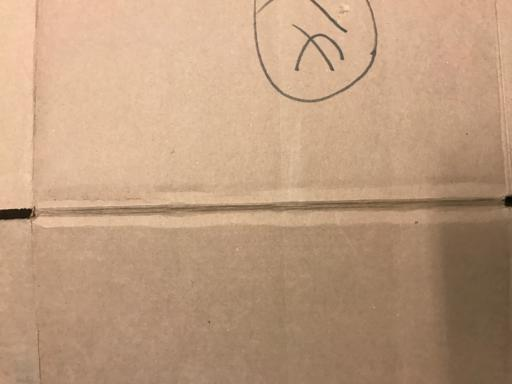

In [3]:
IPython.display.Image(filename='../input/trashnet/dataset-resized/cardboard/cardboard1.jpg') 

In [4]:
import tensorflow as tf
import keras.layers as tkl
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [5]:
directory = '/kaggle/input/trashnet/dataset-resized/'
global garbage_classes
garbage_classes = os.listdir(directory)
print(garbage_classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [6]:
# Dictionary to save our 12 classes
categories = {0: 'metal', 1: 'glass', 2: 'paper', 3: 'trash', 4: 'cardboard', 5: 'plastic'}

print('defining constants successful!')

defining constants successful!


In [7]:
# Dictionary to save our 12 classes
categories_r = {'metal':0, 'glass':1, 'paper':2, 'trash':3, 'cardboard':4, 'plastic':5}


In [8]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [9]:
# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(directory + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
df

,filename,category
0,paper/paper557.jpg,2
1,metal/metal222.jpg,0
2,plastic/plastic338.jpg,5
3,paper/paper495.jpg,2
4,cardboard/cardboard32.jpg,4
...,...,...
2522,metal/metal164.jpg,0
2523,paper/paper582.jpg,2
2524,paper/paper294.jpg,2
2525,paper/paper223.jpg,2


In [10]:
#Change the categories from numbers to names
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

from sklearn.model_selection import train_test_split
# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=42)

In [11]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  2021 validate size =  354 test size =  152


In [12]:
import tensorflow as tf

batch_size=64

IMAGE_WIDTH = 224  
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale =(1/1255.))


train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2021 validated image filenames belonging to 6 classes.


In [13]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator ,  # Our generator 
    output_types = (tf.float32 , tf.float32) , # How we're expecting our output dtype
    output_shapes = ([batch_size , IMAGE_WIDTH , IMAGE_HEIGHT , IMAGE_CHANNELS] , [batch_size , 6]) # How we're expecting our output shape
)

In [14]:
train_generator[0][0].shape

(64, 224, 224, 3)

In [15]:
validation_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale =(1/1255.))


validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    directory, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 354 validated image filenames belonging to 6 classes.


In [16]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale =(1/1255.))

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=directory,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 152 validated image filenames belonging to 6 classes.


In [17]:
X = test_df['category'].values.reshape(-1, 1)

In [18]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder().fit(X)

X = enc.transform(X).toarray()

In [19]:
argmax = []

for x in X:
    argmax.append(np.argmax(x))

In [20]:
test_df['class'] = argmax

In [21]:
test_df

,filename,category,class
0,paper/paper402.jpg,paper,3
1,cardboard/cardboard147.jpg,cardboard,0
2,cardboard/cardboard151.jpg,cardboard,0
3,glass/glass464.jpg,glass,1
4,glass/glass89.jpg,glass,1
...,...,...,...
147,cardboard/cardboard29.jpg,cardboard,0
148,glass/glass247.jpg,glass,1
149,plastic/plastic52.jpg,plastic,4
150,plastic/plastic338.jpg,plastic,4


In [22]:
test_generator[0][1]

array([[0., 0., 0., 1., 0., 0.]], dtype=float32)

# model

In [23]:
import keras
from keras.models import Sequential,Model
from tensorflow.keras import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [24]:
batch_size = 64
epochs = 20
num_classes = 6

In [25]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(IMAGE_WIDTH , IMAGE_HEIGHT , IMAGE_CHANNELS),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [26]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,206 (49.36 MB)

 Trainable params: 12,939,206 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
_train = model.fit(train_generator, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=validation_generator)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731009642.604254      76 service.cc:145] XLA service 0x7b8940004b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731009642.604308      76 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731009642.604311      76 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.2109 - loss: 2.1427 

I0000 00:00:1731009650.964757      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 724ms/step - accuracy: 0.2465 - loss: 1.8808 - val_accuracy: 0.3446 - val_loss: 1.5145
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.4361 - loss: 1.3889 - val_accuracy: 0.4944 - val_loss: 1.2526
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.5315 - loss: 1.2042 - val_accuracy: 0.6017 - val_loss: 1.0830
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.6332 - loss: 1.0405 - val_accuracy: 0.6045 - val_loss: 1.0760
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.6696 - loss: 0.8766 - val_accuracy: 0.6412 - val_loss: 0.9894
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.7531 - loss: 0.6992 - val_accuracy: 0.6215 - val_loss: 0.9779
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.8055 - loss: 0.5666 - val_accuracy: 0.5621 - val_loss: 1.3760
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.8364 - loss: 0.4850 - val_accuracy: 0.6667 - val

In [29]:
model.save('1stmodel.h5')

In [30]:
filenames = test_generator.filenames
nb_samples = len(filenames)

accuracy = model.evaluate(test_generator)

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6503 - loss: 2.6154


In [31]:
print('test loss', accuracy[0])
print('test accuracy', accuracy[1])

test loss 1.8624393939971924
test accuracy 0.7302631735801697


In [32]:
predicted_classes = model.predict(test_generator)

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [33]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [34]:
correct = np.where(predicted_classes==argmax)[0]

In [35]:
print ('Found %d correct labels' % len(correct))

Found 110 correct labels


In [36]:
correct[0]

0

In [37]:
test_df.values[correct[0]][0]

'paper/paper402.jpg'

In [38]:
test_df['predicted_class'] = predicted_classes

In [39]:
test_df.to_csv('test1.csv', index = False)

In [40]:
predicted_classes

array([3, 0, 4, 4, 1, 4, 3, 0, 3, 0, 0, 0, 4, 4, 3, 3, 0, 0, 1, 0, 1, 0,
       4, 0, 1, 1, 2, 4, 4, 1, 4, 1, 5, 1, 3, 3, 3, 1, 5, 2, 0, 0, 2, 3,
       4, 3, 3, 0, 1, 2, 1, 1, 0, 0, 4, 1, 4, 3, 4, 3, 4, 3, 1, 2, 1, 4,
       5, 3, 1, 4, 5, 4, 1, 0, 1, 0, 4, 4, 1, 1, 2, 1, 3, 2, 3, 5, 1, 0,
       2, 3, 4, 3, 0, 1, 0, 4, 4, 3, 0, 3, 0, 4, 2, 2, 3, 5, 2, 2, 4, 2,
       5, 4, 3, 4, 4, 4, 2, 3, 3, 0, 4, 2, 0, 0, 2, 5, 2, 0, 5, 2, 2, 2,
       1, 3, 1, 2, 1, 3, 4, 0, 3, 4, 4, 0, 3, 3, 1, 0, 1, 4, 4, 3])

# results analysys

In [35]:
test_generator[0][0][0].shape

(224, 224, 3)

In [51]:
correct = np.where(predicted_classes==argmax)
correct

(array([  0,   1,   4,   7,   8,  10,  12,  13,  15,  16,  17,  18,  22,
         23,  24,  25,  28,  31,  33,  34,  35,  36,  37,  41,  43,  44,
         45,  46,  47,  50,  51,  53,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  66,  67,  68,  69,  71,  73,  75,  76,  77,  78,
         79,  81,  82,  83,  84,  86,  87,  89,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 103, 104, 106, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127, 129, 130, 133, 134, 135, 136, 138, 140, 141, 143,
        144, 147, 148, 149, 150, 151]),)

In [1]:
test_generator[0][0][0]

NameError: name 'test_generator' is not defined

Found 110 correct labels


/tmp/ipykernel_30/155094819.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


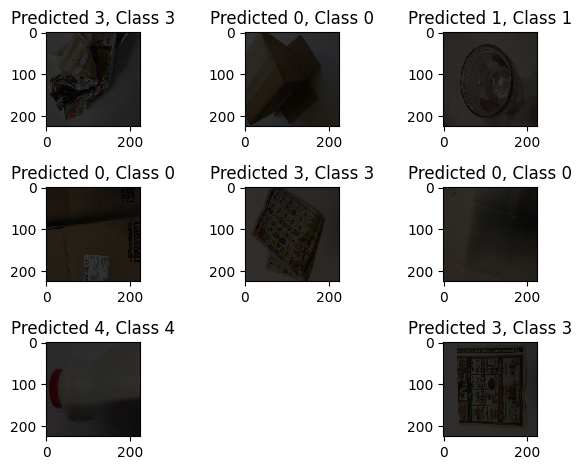

In [53]:
correct = np.where(predicted_classes==argmax)[0]
print ('Found %d correct labels' % len(correct))

for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_generator[correct][0][0])
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], argmax[correct]))
    plt.tight_layout()

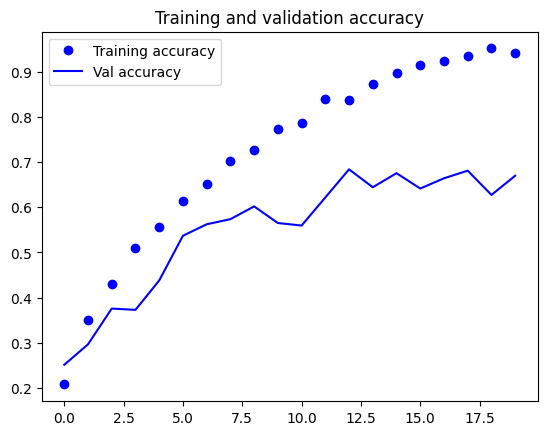

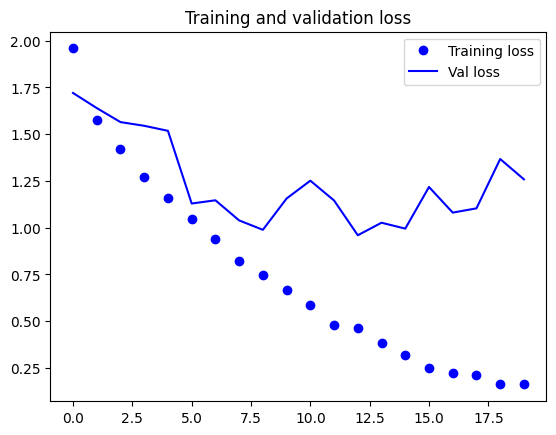

In [69]:
plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Val accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Val loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [45]:
from sklearn.metrics import classification_report

preds = [gen_label_map[item] for item in predicted_classes]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

              precision    recall  f1-score   support

   cardboard       0.76      0.73      0.75        30
       glass       0.75      0.62      0.68        34
       metal       0.57      0.57      0.57        21
       paper       0.87      0.82      0.84        33
     plastic       0.74      0.83      0.78        30
       trash       0.33      0.75      0.46         4

    accuracy                           0.72       152
   macro avg       0.67      0.72      0.68       152
weighted avg       0.74      0.72      0.73       152



In [ ]:
batch_size = 6
epochs = 20
num_classes = 6

In [59]:
_model = Sequential()
_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(IMAGE_WIDTH , IMAGE_HEIGHT , IMAGE_CHANNELS),padding='same'))
_model.add(LeakyReLU(alpha=0.1))
_model.add(MaxPooling2D((2, 2),padding='same'))
_model.add(Dropout(0.25))
_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
_model.add(LeakyReLU(alpha=0.1))
_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
_model.add(Dropout(0.25))
_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
_model.add(LeakyReLU(alpha=0.1))                  
_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
_model.add(Dropout(0.4))
_model.add(Flatten())
_model.add(Dense(128, activation='linear'))
_model.add(LeakyReLU(alpha=0.1))           
_model.add(Dropout(0.3))
_model.add(Dense(num_classes, activation='softmax'))

In [60]:
_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,206 (49.36 MB)

 Trainable params: 12,939,206 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [63]:
_train_dropout = _model.fit(train_generator, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=validation_generator)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 444ms/step - accuracy: 0.1851 - loss: 2.3147 - val_accuracy: 0.2514 - val_loss: 1.7206
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.3152 - loss: 1.6303 - val_accuracy: 0.2966 - val_loss: 1.6398
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.4248 - loss: 1.4307 - val_accuracy: 0.3757 - val_loss: 1.5647
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.4995 - loss: 1.2907 - val_accuracy: 0.3729 - val_loss: 1.5450
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.5422 - loss: 1.1604 - val_accuracy: 0.4379 - val_loss: 1.5179
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.5821 - loss: 1.1198 - val_accuracy: 0.5367 - val_loss: 1.1291
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.6424 - loss: 0.9538 - val_accuracy: 0.5621 - val_loss: 1.1464
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.7121 - loss: 0.7839 - val_accuracy: 0

In [64]:
_model.save('_model.h5')

In [65]:
test_eval2 = _model.evaluate(test_generator)

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6821 - loss: 1.5242


In [67]:
print('Test loss:', test_eval2[0])
print('Test accuracy:', test_eval2[1])

Test loss: 1.2126820087432861
Test accuracy: 0.7171052694320679


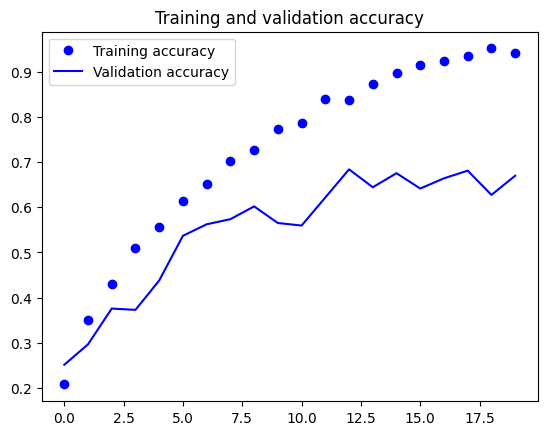

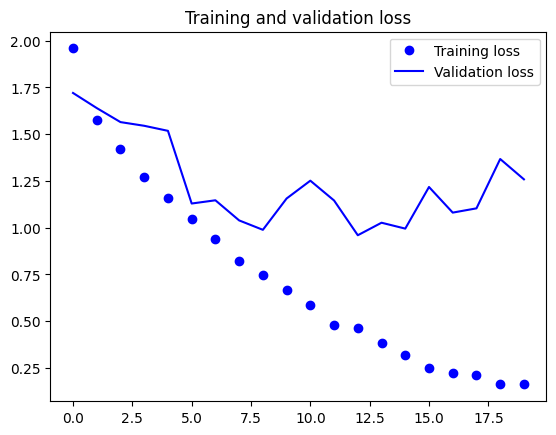

In [68]:
accuracy = _train_dropout.history['accuracy']
val_accuracy = _train_dropout.history['val_accuracy']
loss = _train_dropout.history['loss']
val_loss = _train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()